In [1]:
import torch
import numpy as np
from model import cp_2_k_mask
from config import args
from dataset import Enigma_simulate_c_2_p, Enigma_simulate_cp_2_k_limited, Enigma_simulate_cp_2_k
from torch.utils.data import DataLoader
import math
from torchsummary import summary
from tqdm import tqdm

Copying the compiled weight to regular models

In [2]:
# Load trained model's weights and config
ckpt = torch.load('tensorboard/seq5/CP2K_RNN_ENC_ckpt.pt')
ckpt_args = ckpt['args']

# Initialize new model by configs
model = cp_2_k_mask(args=ckpt_args, out_channels=26)
model.to('cuda')
model.eval()

# Load weights, calculate the number of parameters
weights = []
num_param = 0
for k, v in ckpt['weights'].items():
    weights.append(v)
    num_param += np.prod(v.shape)
print(f"Parameters: {num_param}")

# Copying weights from compile model to new model
for idx, (k, v) in enumerate(model.state_dict().items()):
    # We have to copying like this, I am so confused
    v *= 0
    v += weights[idx].detach()

# Set the model to evaluate mode
model.eval()

Parameters: 27408974


cp_2_k_mask(
  (networks): ModuleList(
    (0): RNN_encoder(
      (enc): LSTM(512, 512, num_layers=2, dropout=0.2, bidirectional=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (linear1): Linear(in_features=1024, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=1024, bias=True)
          (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
    )
  )
  (linear_projectors): Linear(in_features=1024, out_features=78, bia

Running a mini batch of examples

In [3]:
dataset = Enigma_simulate_cp_2_k_limited(args=args)
dataloader = DataLoader(
        dataset=dataset,
        batch_size=512,
        collate_fn=dataset.collate_fn_padding,
        shuffle=True
    )

for inputs, targets, masks in dataloader:
    inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')


    outputs = model(inputs, masks)

    print(f"Input shape: {inputs.shape} {'[seq, batch, feats]'}\n"
          f"Target shape: {targets.shape}  {'[rotor, seq, batch]'}\n"
          f"Mask shape: {masks.shape}  {'[batch, seq]'}\n"
          f"Output shape: {outputs.shape}  {'[rotor, seq, batch, feats]'}")
    break

true_positive = 0
samples = 0

outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
for rotor in range(outputs_indices.shape[0]):
    mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
    true_positive += mask.sum()
    samples += math.prod(mask.shape)

print(f"Acc: {true_positive / samples}")

Input shape: torch.Size([30, 512, 52]) [seq, batch, feats]
Target shape: torch.Size([3, 30, 512])  [rotor, seq, batch]
Mask shape: torch.Size([512, 30])  [batch, seq]
Output shape: torch.Size([3, 30, 512, 26])  [rotor, seq, batch, feats]
Acc: 0.9989583492279053


In [4]:
# Make prediction based on user's inputs
from dataset import cipher_plain_text_2_tensor
inputs, masks = cipher_plain_text_2_tensor('VMPDTAJYTXDZNEFOSOTPJOYSMO', 'WEARETHECHAMPIONANDTHEBEST') # Predict on usr inputs
inputs, masks = inputs.to('cuda'), masks.to('cuda')


# Make prediction
with torch.no_grad():
    outputs = model(inputs, masks).argmax(dim=-1).squeeze(-1) # -> shape [rotor, seq]

# print the prediction at the first postion, which is the initial states
print(f"Prediction: {chr(ord('A') + outputs[0, 0])}"
      f"{chr(ord('A') + outputs[1, 0])}"
      f"{chr(ord('A') + outputs[2, 0])}")

Prediction: AES


In [5]:
# Testint accuracy in different length
testing_args = args
results = {}


for length in range(5, 51):
    testing_args['SEQ_LENGTH'] = [length, length]
    dataset = Enigma_simulate_cp_2_k_limited(args=testing_args, mode='test')
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=1024,
        collate_fn=dataset.collate_fn_padding,
        shuffle=False,
        drop_last=False
    )

    # Tracking
    true_positive = 0
    samples = 0

    bar = tqdm(dataloader, leave=True)
    bar.set_description_str(f"Length: {length}")

    for inputs, targets, masks in bar:
        inputs, targets, masks = inputs.to('cuda'), targets.to('cuda'), masks.to('cuda')

        # Making prediction
        # with torch.cuda.amp.autocast():
        with torch.no_grad():
            outputs = model(inputs, masks)

            # Compute accuracy
            outputs_indices = torch.argmax(outputs, dim=-1) # -> [rotor, seq, batch]
            for rotor in range(outputs_indices.shape[0]):
                mask = outputs_indices[rotor][~masks.T] == targets[rotor][~masks.T]
                true_positive += mask.sum()
                samples += math.prod(mask.shape)

        # Set bar's postfix
        bar.set_postfix_str(f"Acc: {(true_positive / samples).item()}")

    # Output and record the result
    results[length] = (true_positive / samples).item()

Length: 50: 100%|█████████████████████████████████████████████| 35/35 [00:17<00:00,  1.98it/s, Acc: 0.9667965769767761]


Ploting the results

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50] [0.10465407 0.15196384 0.22513655 0.32788914 0.45147422 0.57692498
 0.70743936 0.82386726 0.89513302 0.93700147 0.96136212 0.97040063
 0.9761194  0.98043942 0.98380119 0.98409951 0.98676318 0.99061304
 0.99444276 0.99602002 0.99751139 0.99798161 0.99822634 0.99863011
 0.9988032  0.99897021 0.99903494 0.9991318  0.99916893 0.99917388
 0.99922216 0.99926823 0.99927938 0.99929726 0.99932849 0.99934071
 0.99936354 0.99937934 0.99938869 0.99941099 0.99941736 0.99942297
 0.99715543 0.98894757 0.97780079 0.96679658]


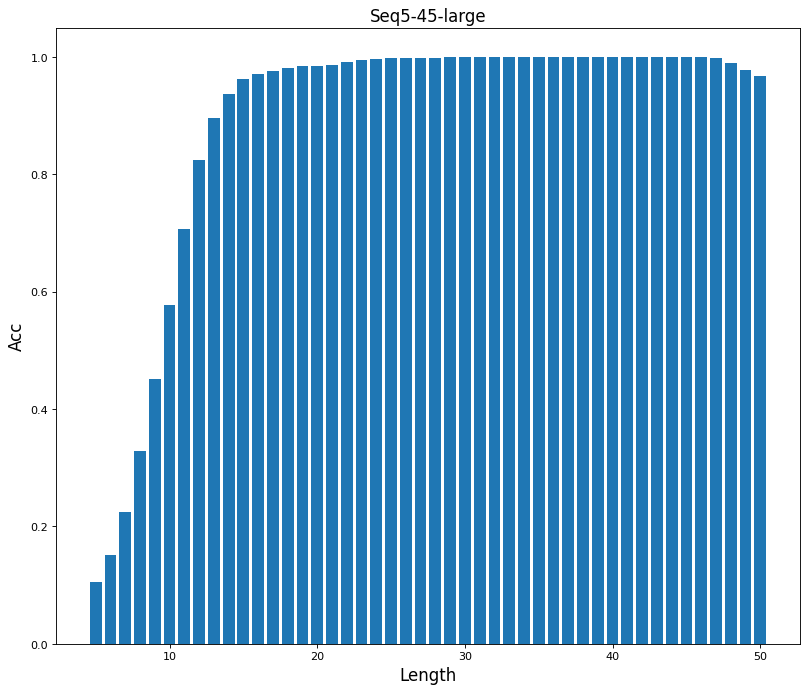

In [8]:
import matplotlib.pyplot as plt
import numpy as np


x = list(results.keys())
y = list(results.values())

x, y = np.array(x), np.array(y)
print(x, y)

fig, ax = plt.subplots(figsize=(12, 10), dpi=80)
ax.bar(x,height=y)
plt.title('Seq5-45-large', fontsize=15)
ax.set_ylabel('Acc', fontsize=15)
ax.set_xlabel('Length', fontsize=15)
plt.show()
# ax.plot(bins, y, '--')

In [7]:
plt.savefig('Seq5-45')

<Figure size 640x480 with 0 Axes>